# **Lab: Viscous flow**
**Gustav Grevsten**

# **Abstract**

In this report, the FEniCS Python library was used in order to implement a finite element solution to the Stokes equations in 2D. It then demonstrates the stability of the solution under the Taylor-Hood mixed element conditions and instability of the equal order interpolation.

# **About the code and report**

Most of the code as well as the introduction were provided courtesy of Prof. Johan Hoffman (jhoffman@kth.se) as a part of the course DD2365, Advanced Computation in Fluid Mechanics, at KTH Royal Institute of Technology, Stockholm, Sweden.

# **Set up environment**

In [1]:
# Load neccessary modules.
import numpy as np
import matplotlib.pyplot as plt

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

--2023-04-19 21:43:42--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-19 21:43:42 (38.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 


# **Method**

For this lab, a mesh with a uniform mesh size of $h = \frac{1}{32}$ was used with the dimensions $10 \times 5$. This mesh contained a circular hole in the center with a radius of $r=0.4$. The mesh was refined around the hole once in a radius of $1$ surrounding the center of the hole.

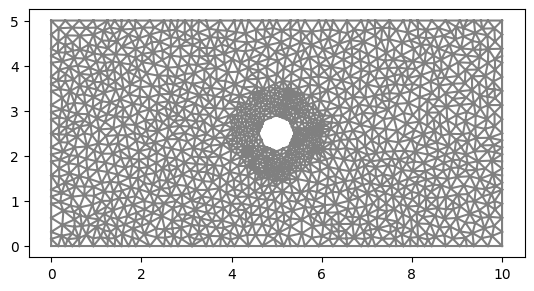

In [2]:
def rect_mesh(base, height, holes, levels = 0, resolution = 32):

  geometry = Rectangle(Point(0.0,0.0), Point(base,height))

  # Each hole is a list in the format [centre coordinate = [x, y], radius]
  for hole in holes:
    geometry -= Circle(Point(hole[0][0],hole[0][1]), hole[1])

  mesh = generate_mesh(geometry, resolution)

  # Local mesh refinement (specified by a cell marker)
  for hole in holes:
    for i in range(0,levels):
      cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
      for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()
        if p.distance(Point(hole[0][0],hole[0][1])) < 1:
          cell_marker[cell] = True
      mesh = refine(mesh, cell_marker)

  return mesh

mesh = rect_mesh(10, 5, [[[5, 2.5], 0.4]], 1)

plt.figure()
plot(mesh)
plt.show()

This mesh is then used in order to define the finite element function space using continuous piecewise interpolating polynomials. For the Taylor-Hood mixed element, a continuous piecewise quadratic approximation is used for the velocity and a continuous piecewise linear approximation is used for the pressure.

**Define finite element approximation spaces**

In [3]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

**Define boundary conditions**

In [4]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = 10
YMIN = 0.0; YMAX = 5
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

# **Results**

We first verify that the Taylor-Hood mixed element is stable, using the approximation spaces as defined in the method section:

DEBUG:UFL:Blocks of each mode: 
  7	full
DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  1	full


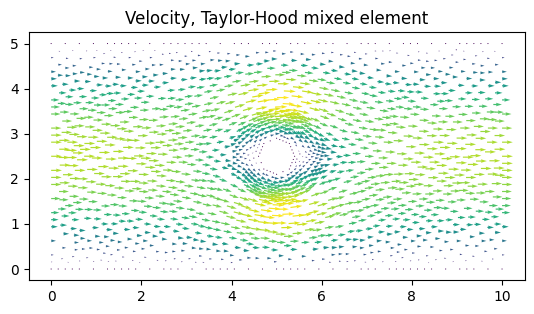

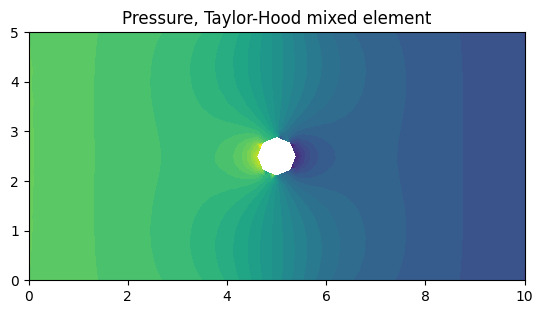

In [5]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w)

u1 = project(u, V)
p1 = project(p, Q)

# Plot solution
plt.figure()
plot(u1, title="Velocity, Taylor-Hood mixed element")

plt.figure()
plot(p1, title="Pressure, Taylor-Hood mixed element")
        
plt.show()

Here we can see the fluid flow behaves largely as expected, with the flow circulating the circle and the pressure being higher on the left, which is facing the incoming fluid.

We then modify the approximation space into equal order interpolation of the velocity and pressure, using linear interpolation for both, showing that the solution becomes unstable:

**Define finite element approximation spaces**

In [6]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 1)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

**Define boundary conditions**

In [7]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = 10
YMIN = 0.0; YMAX = 5
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

DEBUG:UFL:Blocks of each mode: 
  6	full
DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
DEBUG:UFL:Blocks of each mode: 
  1	full


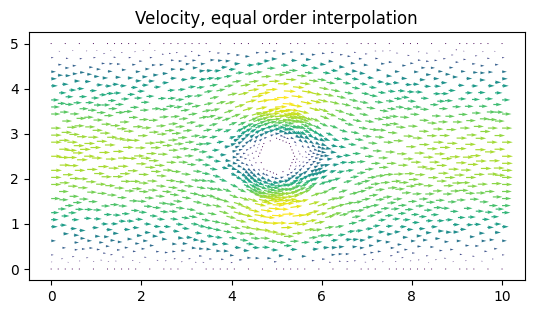

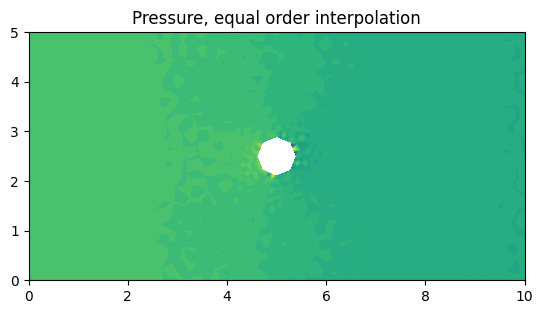

In [8]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w)

u1 = project(u, V)
p1 = project(p, Q)

# Plot solution
plt.figure()
plot(u1, title="Velocity, equal order interpolation")

plt.figure()
plot(p1, title="Pressure, equal order interpolation")
        
plt.show()

As can be seen in the plots above, the solution for the velocity looks largely similar, but the pressure becomes highly non-physical, with unusual oscillations. This demonstrates that the solution is indeed unstable.

Finally, we modify the boundary conditions to make the flow go in the opposite direction:

**Define finite element approximation spaces**

In [9]:
# Generate mixed finite element spaces (for velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

**Define boundary conditions**

In [10]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = 10
YMIN = 0.0; YMAX = 5
uin = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())

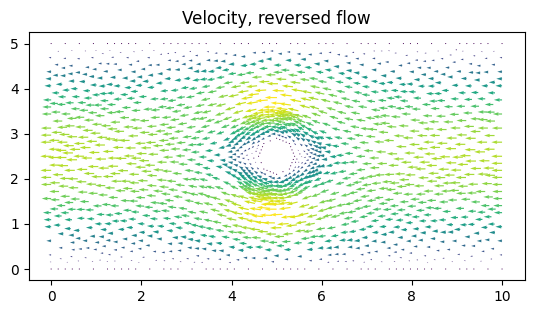

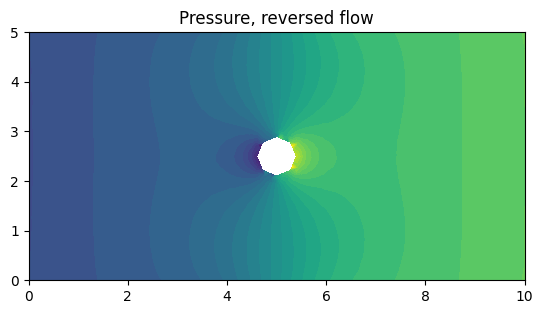

In [11]:
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define variational problem on residual form: r(u,p;v,q) = 0
residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx + gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx )

# Solve algebraic system 
solve(residual == 0, w)

u1 = project(u, V)
p1 = project(p, Q)

# Plot solution
plt.figure()
plot(u1, title="Velocity, reversed flow")

plt.figure()
plot(p1, title="Pressure, reversed flow")
        
plt.show()

Again, we retrieve an expected result, showing the almost perfect symmetry of the solution when the flow is changed in the other direction.

# **Discussion**

The results have demomstrated the symmetry of the solution when changing the direction of flow. It has also confirmed that the Taylor-Hood mixed element method is stable, whereas equal order interpolation of both velocity and pressure, where both interpolations use linear polynomials, resulted in an unstable solution for the pressure. This is because the equal order interpolation does not satisfy the inf-sup condition. It is worth noting that we should see similar results when using second order polynomials for both interpolations.